# Sistemas de Recomendación - Netflix Prize Challenge

Vamos a implementar un sistema de recomendación a través de un filtro colaborativo. Como son varios los pasos que debemos dar, está dividido en dos notebooks. Uno orientado al preprocesamiento y exploración de datos, y otro a la implementación de las técnicas que vimos.

Algunas referencias útiles, además de las mencionadas en la presentación:
* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
* https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

El dataset puede ser descargado [acá](https://www.kaggle.com/netflix-inc/netflix-prize-data)

Importante leer el archivo `README.md` para la descripción de los archivos.

## Grandes Volúmenes de Datos

Uno de los desafíos que plantea este dataset es que es bastante "grande". Esto quiere decir que, si lo cargamos completo, ocupa bastante lugar en nuestra memoria RAM. Además, cada tarea puede llevar mucho tiempo. Entonces, es necesario plantear una estrategia para abordarlo. Existen varias posibilidades, mencionamos algunas:
1. Recortar una parte del dataset con la que sí podamos trabajar. Esta parte tiene que ser lo suficientemente representativa del set original. Para estar seguros/as de ello es fundamental hacer una buena exploración de datos. Con ese recorte, entrenamos y evaluamos nuestro modelo, y optimizamos parámetros (CV). Una vez que ya estamos seguro de que nuestro flujo de trabajo es apropiado, podemos probar agrandar la porción de datos con la que entrenamos o utilizar otro recorte del dataset. Eventualmente, podemos llegar a usar todo el dataset para entrenar y evaluar si nuestra computadora lo permite. **NOTA**: el recorte se hace para que se pueda cargar en memoria los datos pero también para que cada iteración lleve un tiempo razonable.
2. **Aprendizaje incremental**: algunos modelos puede ser entrenados mostrándoles el dataset de a pedazos. Es decir, no necesitan ver todo el dataset a la vez. Un ejemplo son las redes neuronales, que "ven" muchas pasadas del dataset en *epochs* y *minibatches*. Algunos modelos en Scikit-learn tienen la función `partial_fit` que permite hacer eso. Pueden leer un poco al respecto [acá](https://scikit-learn.org/stable/modules/computing.html). Pandas también tiene funciones que permiten cargar el dataset de a trozos.
3. Utilizar servicios en la nube. Esta opción no es excluyente con las anteriores. Antes de utilizar algún entorno en la nube, está bueno haber hecho pruebas en nuestra computadora y ya haber optimizado bastante el flujo de trabajo. Recuerden que los servicios en la nube suelen ser pagos.
4. Existen librerías orientadas a trabajar con grandes datos. Un ejemplo es [Dask](https://dask.org/).

## 0. Algunos preliminares

Mientras miras el estado de la memoria RAM - averiguar cómo hacer esto en tu sistema operativo, ¡no es dificil! -, crea un arreglo 2-D de unos en numpy de forma `(10000,10000)`.

In [1]:
import numpy as np

In [2]:
N = 10000
unos = np.ones((N,N))
print(unos)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [3]:
del unos # Borra la variable

¿Qué tipo de dato es `ones`?¿Y sus elementos? Crear el mismo arreglo, pero convertir los elementos en *np.int8*

In [4]:
unos = np.ones((N,N)).astype(np.int8)
print(unos)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


¿Ocupa el mismo espacio en memoria?¿Cuál es al diferencia entre un `float` y un `int`?

Por las dudas reiniciar el Kernel antes de continuar y correr a partir de la sección siguiente.

## 1. Carga de Datos y preparación del Dataset

Para comprender los pasos que haremos a continuación, ten en cuenta que necesitamos un dataset donde cada fila represente un usuario, una película y la calificación del usuario a esa película. Es decir, tiras de tres componentes. Hay otra información que puede ser útil, pero con esos tres datos ya podemos implementar un filtro colaborativo.

Lamentablemente, el dataset no viene en esa forma, por lo que deberemos preprarar el dataset para adaptarlo a ese formato. Lee detenidamente las celdas de código que te dejamos para preparar el dataset. Pero no te preocupes si no las entiendes del todo. Tal vez descubras que algunas cosas se podrían haber hecho de una manera más simple. ¡No hay una sola forma de hacer las cosas!

**Nota:** algunas celdas tardan en correr.

Empezamos cargando uno de los archivos con calificaciones para explorarlo. Como son archivos grandes y van a ocupar bastante lugar en memoria, no vamos a cargar la última columna con fechas.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    return df

df1 = load_data('/content/drive/MyDrive/Colab Notebooks/netflix-prize-data/combined_data_1.txt')
print(df1.shape)

(24058263, 2)


In [8]:
df1.head()

,User,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


¿Cómo sabemos a qué película corresponde cada calificación?¿Dónde está es información? 

Vamos a contar cuántas películas hay en `df1` e identificarlas. Para ello, cargamos `movie_titles.csv`. Como no nos interesa el año (al menos, por ahora), no lo traemos.

In [9]:
df_title = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


De esta forma, podemos obtener el nombre de una película dado su `Id`.

In [10]:
movie_id = 1
print(df_title.loc[movie_id].Name)

Dinosaur Planet


Para contar cuántos identificadores hay, vamos a usar la siguiente información: al lado del identificador de la película, la columna `Rating` de `df1` tiene un `NaN`.

In [11]:
movies_ids_df1 = df1.User[df1.Rating.isna()].values
print(movies_ids_df1)
print(len(movies_ids_df1))

['1:' '2:' '3:' ... '4497:' '4498:' '4499:']
4499


¿En qué formato está? Si queremos usarlo para pasar de identificador al nombre, debemos llevarlo a enteros. Asumimos que no hay ningun repetido:

In [12]:
movies_ids_df1 = np.arange(1,len(movies_ids_df1) + 1)
print(movies_ids_df1)

[   1    2    3 ... 4497 4498 4499]


**Agregando el Movie_id**

Vamos a agregar una columna al Dataframe con el Id de la película a la que corresponde la calificación. Es decir, queremos que el DataFrame tenga las siguientes columnas: `User`, `Rating`, `Movie_id`. Para ello, necesitamos saber dónde están ubicados los identificadores, para completar en el medio con la película correspondiente.

Primero, seleccionamos los índices donde aparecen los identificadores.

In [13]:
df1_nan = pd.DataFrame(pd.isnull(df1.Rating))
df1_nan = df1_nan[df1_nan['Rating'] == True]
idx_movies_ids = df1_nan.index.values
print(idx_movies_ids)

[       0      548      694 ... 24056849 24057564 24057834]


Queremos crear un vector de tantas instancias como `df1`, donde en cada lugar esté el `Movie_id` al cual corresponde la calificación. Como tenemos los índices donde está cada `Movie_id`, podemos obtener cuántas calificaciones hay de cada película.

In [14]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df1.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
#https://numpy.org/doc/stable/reference/generated/numpy.diff.html  #realiza la diferencia de v[i+1]-v[i]
cantidad_criticas

array([ 548,  146, 2013, ...,  715,  270,  429])

In [15]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df1[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

Agregamos esa columna al dataset y, ahora sí, convertimos a tipos de datos que ocupen menos lugar.

In [16]:
df1['Movie_id'] = columna_movie_id
del columna_movie_id

df1.dropna(inplace = True)
df1['User'] = df1['User'].astype(int)
df1['Movie_id'] = df1['Movie_id'].astype(np.int16)
df1['Rating'] = df1['Rating'].astype(np.int8)

gc.collect()

182

In [17]:
df1.head()

,User,Rating,Movie_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1


Ya contamos con un dataframe con calificaciones de usuarios a películas.

Una opción muy útil es guardar el dataset modificado en nuevo archivo y, a partir de ahora, trabajar con esa versión. Esto hará que no tengas que hacer el preprocesamiento cada vez que empieces a trabajar y, además, ahorrarnos toda la "basura" que Python pueda ir dejando en la RAM.

Por eso, guardamos el dataset modificado en un nuevo archivo.

In [18]:
if True:
    df1.to_csv('/content/drive/MyDrive/Colab Notebooks/netflix-prize-data/combined_data_1_with_movie_id.csv', index= False)

## 2. Exploración del Dataset

Ahora que ya tenemos un dataset prolijo, es momento de explorarlo.

Responde - al menos - las siguientes preguntas, siempre que se pueda con un lindo gráfico (¡pensar bien cómo!):

1. ¿Cuántos usuarios únicos hay?
1. ¿Cuántas películas calificó cada usuario?
1. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?
1. ¿Cómo es la distribución del número de calificaciones por usuario?
1. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

**¿Se te ocurre alguna otra pregunta para explorar?**Por ejemplo, ¿hay alguna relación entre la cantidad de calificaciones que ponen los/as usuarios/as y el valor de ellas? ¿Usuarios que califican mucho tienden a poner calificaciones positivas o negativas?¿Y los que califican poco?

Arrancamos abriendo el dataset ya modificado:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [20]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix-prize-data/combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [21]:
df1.dtypes


User        int64
Rating       int8
Movie_id    int64
dtype: object

Y los títulos

In [22]:
df_title = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()
print(df_title.shape)

(17770, 1)


In [23]:
#¿Cuántos usuarios únicos hay?
U_Df=np.unique(df1.User)
print(U_Df.shape)

(470758,)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


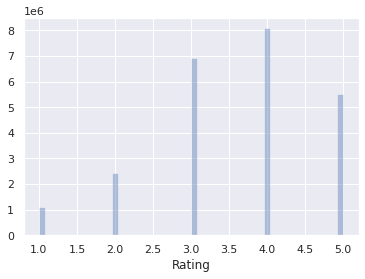

In [24]:
#    ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?
sns.distplot(df1['Rating'],kde=False)
#se concluye que la mayoría de los usuarios tienden a clasificar con buenos valores las películas y hay menor cantidad que no ha disfrutado de las mismas.


In [25]:
#¿Cuántas películas calificó cada usuario?
print(df1['User'].value_counts(ascending=False))



305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
           ... 
791049        1
99015         1
47493         1
119728        1
2355355       1
Name: User, Length: 470758, dtype: int64


In [26]:
#¿Cómo es la distribución del número de calificaciones por usuario?
#¿hacer un get dummies?


In [27]:
#¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?
variable=df1.pivot_table(index=['Movie_id'], aggfunc='size')
var=variable.sort_values(ascending=False)
v=var.to_frame()

###necesito los nombres que le pone a las filas el pivot table.. uso lo de la siguiente pagina:
#https://www.geeksforgeeks.org/how-to-get-rows-index-names-in-pandas-dataframe/
data=v
Lista_name=list((data.index).T)

Lista_name=list((data.index).T)

print(var)

movie_id = Lista_name[0]
print('La película con más calificaciones es: ',df_title.loc[movie_id].Name)
movie_id = Lista_name[-1]
print('La película con menos califiaciones es: ',df_title.loc[movie_id].Name)

Movie_id
1905    193941
2152    162597
3860    160454
4432    156183
571     154832
         ...  
4294        44
915         43
3656        42
4338        39
4362        36
Length: 4499, dtype: int64
La película con más calificaciones es:  Pirates of the Caribbean: The Curse of the Black Pearl
La película con menos califiaciones es:  Bram Stoker's: To Die For
